In [1]:
import pandas as pd
import numpy as np
import random as rd
# from sklearn.decomposition import PCA
# from sklearn import preprocessing
import matplotlib.pyplot as plt 
import os
import time  
import sys
sys.path.append('os.getcwd()')
from scipy import signal
from scipy.signal import find_peaks
from tkinter import filedialog
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython.display import Javascript, display
from IPython.display import Audio

# get_ipython().run_line_magic('load_ext', 'autoreload')
# get_ipython().run_line_magic('autoreload', '2')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="hide/show code"></form>''')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# #%%
# HTML('''<script>
# code_show_err=false; 
# function code_toggle_err() {
#  if (code_show_err){
#  $('div.output_stderr').hide();
#  } else {
#  $('div.output_stderr').show();
#  }
#  code_show_err = !code_show_err
# } 
# $( document ).ready(code_toggle_err);
# </script>
# To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:


def read_mech(file_full_path):
    return pd.read_excel(file_full_path, names = ['f', 'd', 't'] , header=33, usecols=[0,1,2]).dropna()

#### Reading acoustic data

def read_ac(file_full_path):
    return pd.read_csv(file_full_path, sep=" ", names=['p','t','x'], header=2, engine='python').drop(columns=['x']) 

### Folder exploring

def get_file_paths(dir_mec=r'..{}Dados Mecânicos{}Padrões'.format(os.sep,os.sep), 
                   dir_ac=r'..{}Dados Acústicos{}Padrões'. format(os.sep,os.sep), 
                   load_sync=False, sync_path=False):
    filepaths_mec = []
    files_mec = []
    file_source = []
    filepaths_ac = []
    files_ac = []

    for subdir, dirs, files in os.walk(dir_mec):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".XLS"):
                    filepaths_mec.append(subdir)
                    files_mec.append(file)
                    
                    
    for subdir, dirs, files in os.walk(dir_ac):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".txt"):
                    filepaths_ac.append(subdir)   
                    files_ac.append(file)
                    
    filepaths_mec = [filepaths_mec[index] for index in np.argsort(files_mec)]
    files_mec = np.sort(files_mec)
    filepaths_ac = [filepaths_ac[index] for index in np.argsort(files_ac)]
    files_ac = np.sort(files_ac)
    
    filepath_mec = [filepaths_mec[ifile]+os.sep+files_mec[ifile] for ifile in range(len(files_mec)-1)]
    filepath_ac = [filepaths_ac[ifile]+os.sep+files_ac[ifile] for ifile in range(len(files_ac)-1)]
    
    if load_sync:
        if not sync_path:
            from tkinter import Tk
            root = Tk()
            root.withdraw() 
            root.update()
            filename = filedialog.askopenfilename(title = "Select sync_file")
        else:
            filename = sync_path
        old_df = pd.read_excel(filename)
        sync_cutpoints = old_df['cutpoints'].values
        filenames = [element.rsplit(os.sep, 1)[1][0:-4] for element in filepath_ac]
        current_info = pd.DataFrame(filepath_ac, columns=['path_ac'])
        current_info['path_mec'] = filepath_mec
        current_info['filenames'] = filenames
        current_info = current_info.set_index('filenames')
        current_info = current_info.reindex(index=old_df['filename'])
        current_info = current_info.reset_index()
        filepath_ac = current_info['path_ac'].values
        filepath_mec = current_info['path_mec'].values
    else:
        sync_cutpoints=[]
    return filepath_mec, filepath_ac, sync_cutpoints

#### Calculation functions

def fir_highpass():

    fir = [ 0.0065, -0.0025, -0.0114, -0.0073, -0.0160, 0.0070,    0.0075,
           -0.0108,    0.0192,    0.0055,    0.0137,    0.0187,    0.0034,    0.0333,   
           -0.0079,    0.0135,    0.0061,   -0.0364,    0.0123,   -0.0717,   -0.0261,
           -0.0531,   -0.1251,    0.0193,   -0.2383,    0.0839,    0.7123,
            0.0839,   -0.2383,    0.0193,   -0.1251,   -0.0531,   -0.0261,
           -0.0717,    0.0123,   -0.0364,    0.0061,    0.0135,   -0.0079,
            0.0333,    0.0034,    0.0187,    0.0137,    0.0055,    0.0192,   -0.0108,    0.0075,   
            0.0070,   -0.0160,   -0.0073,   -0.0114,   -0.0025,    0.0065]
    a = np.ones(len(fir))
    return fir, a

def iir_highpass(sr=51200, order_filt=4, cutoff_f=10000):
    
    sos = signal.butter(order_filt, cutoff_f, btype='high', analog=False, fs=sr, output='sos')
    sos =  np.array([[0.9388, -1.8776, 0.9388, 1.0000, -1.8705, 0.8846],
              [0.9421,   -0.9421, 0.0,  1.0000,   -0.8842, 0]])

    return sos

def filt_data(data, iir=True, show=False):
    
    if iir:
        sos = iir_highpass()
        w, h = signal.sosfreqz(sos, fs=51200)
        y = signal.sosfiltfilt(sos, data)
    else:
        
        b, a = fir_highpass()
        w, h = signal.freqz(b)
        y = signal.filtfilt(b, 1, data)
    
    if show:
        
        fig, ax1 = plt.subplots()
        ax1.set_title('Digital filter frequency response')
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
    
    
    return y    

def calc_linear_distance(f, d):
    linear_distance=0
    for j in np.arange(1,len(f)):
        a = (f[j] - f[j-1])**2
        b = (d[j] - d[j-1])**2

        h = np.sqrt(a+ b)
        linear_distance += h

    return linear_distance


def sync_data(p, t_ac, operation_threshold, peak_detection_treshold,SPL, duration_mec, duration_old, fs_ac):
    p_full = p
    t_ac_full = t_ac

    cut_point,_ = find_peaks(p, height=operation_threshold)

    if t_ac[cut_point[0]] > 6:
        cut_point[0] = 6*fs_ac
    p = p_full[cut_point[0]:cut_point[-1]]
    t_ac = t_ac_full[cut_point[0]:cut_point[-1]]

    max_location, _ = find_peaks(p, height=max(abs(p))*0.9)
    
    cut_point_2,_ = find_peaks(SPL(p), height=peak_detection_treshold)

    # print('{} <= {} <={}'.format(cut_point_2[0],max_location, (cut_point_2[0] + int(duration_old*fs_ac))))

    if max_location > cut_point_2[0]:

        while not cut_point_2[0] <= max_location <= (cut_point_2[0] + int(duration_old*fs_ac)):
            cut_prev = cut_point_2[0]
            cut_point_2 = np.delete(cut_point_2,0, axis=0)
            if max_location - cut_point_2[0] > 51200:
                cut_point_2 = np.delete(cut_point_2,[0,1,2,3,4])
            if len(cut_point_2)==0:
                cut_point_2 = [0, 0]
            # print('{} - {} <= {} <={}'.format(cut_adjust, cut_point_2[0],max_location, cut_point_2[0] + int(duration_old*fs_ac)))
            if cut_prev > cut_point_2[0]:
                cut_point_2,_ = find_peaks(SPL(p), height=peak_detection_treshold)
                break

    p = p[cut_point_2[0]:cut_point_2[0] + int(duration_mec*fs_ac)]
    t_ac = t_ac[cut_point_2[0]:cut_point_2[0] + int(duration_mec*fs_ac)]
    sync_point = cut_point[0] + cut_point_2[0]
    duration_ac = t_ac[-1] - t_ac[0]

    if duration_ac/duration_old < 0.8:
        cut_point,_ = find_peaks(SPL(p_full), height=operation_threshold)
        if t_ac_full[cut_point[0]] > 6:
            cut_point[0] = 6*fs_ac
        p = p_full[cut_point[0]:cut_point[-1]]
        t_ac = t_ac_full[cut_point[0]:cut_point[-1]]

        cut_point_2,_ = find_peaks(SPL(p), height=peak_detection_treshold)

        p = p[cut_point_2[0]:cut_point_2[0] + int(duration_mec*fs_ac)]
        t_ac = t_ac[cut_point_2[0]:cut_point_2[0] + int(duration_mec*fs_ac)]
        duration_ac = t_ac[-1] - t_ac[0]
        sync_point = cut_point[0] + cut_point_2[0] 

    return p, t_ac, duration_ac, sync_point

In [4]:
filter_flag = False
fs_ac = 51200
operation_threshold = 50
peak_detection_treshold = 52
threshold_f = 0.049
prominence_threshold = 10
SPL_threshold = 50
savepath = 'Validacao_crispness_fir.xls'
max_duration = 0
load_sync=True
sync_path='fineSync_arimi_full_data_55db.xls'

ac_headers = ["spl_max", "spl_10", "spl_eq", "npeaks_ac", "duration"]
mec_headers = ["linear_distance", "max_force", "mean_force", "area", "peaks_F", "duration"]
all_data_mec = []
calc_data_mec = []
all_data_ac = []
calc_data_ac = []
cut_points = []
SPL = lambda x:20*np.log10(abs(x/20e-6))

filepath_mec, filepath_ac,cutpoint_prev = get_file_paths(load_sync=load_sync, sync_path=sync_path)
t0 = time.process_time()


In [5]:
iFile = 0
delay = 0
global iFile, delay, new_sync, SPL_threshold

file_index = len(filepath_mec)

### Select file:

In [6]:
@interact
def show_images(file=[element.rsplit(os.sep, 1)[1][0:-4] for element in filepath_ac]):
    global iFile
    all_files = [element.rsplit(os.sep, 1)[1][0:-4] for element in filepath_ac]
    iFile = [index for index in np.arange(len(all_files)) if all_files[index]==file][0]
    print(iFile)
    

interactive(children=(Dropdown(description='file', options=('barrate1', 'barrate2', 'barrate3', 'barrate4', 'b…

In [7]:
text = widgets.Text()
text.value = str(SPL_threshold)
def handle_submit(sender):
    print(SPL_treshold)
    
text.on_submit(handle_submit)

#### Test SPL Treshold

In [70]:
def run_all(ev):
    global iFile
#     if iFile < file_index-2:
#         iFile = iFile+1
#     else:
#         iFile = 0  
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index(), IPython.notebook.get_selected_index()+7)'))

button = widgets.Button(description="Process SPL Treshold")
button.on_click(run_all)
sidebyside = widgets.HBox([button, text])
## Finally, show.
display(sidebyside)

<IPython.core.display.Javascript object>

In [71]:
delay = 0
cutpoint_previous = cutpoint_prev


SPL_threshold = float(text.value)

file_full_mec = filepath_mec[iFile]

df = read_mech(file_full_mec)   
if max_duration == 0:
    f = df['f'].values
    d = df['d'].values
    t_old = df['t'].values
    t_mec = df['t'].values
else:
    f = df['f'].values[:int(max_duration*500)]
    d = df['d'].values[:int(max_duration*500)]
    t_old = df['t'].values
    t_mec = df['t'].values[:int(max_duration*500)]

peaks_F, _ = find_peaks(f, prominence=threshold_f)    
linear_distance = calc_linear_distance(f,d)
max_force = max(f)    
mean_force = np.mean(f)
duration_mec = t_mec[-1] - t_mec[0]
duration_old = t_old[-1] - t_old[0]
area = np.trapz(f, dx = 1/499)
npeaks_f = len(peaks_F)

## Acoustic
file_full_ac = filepath_ac[iFile]    
df = read_ac(file_full_ac)

File 71/125


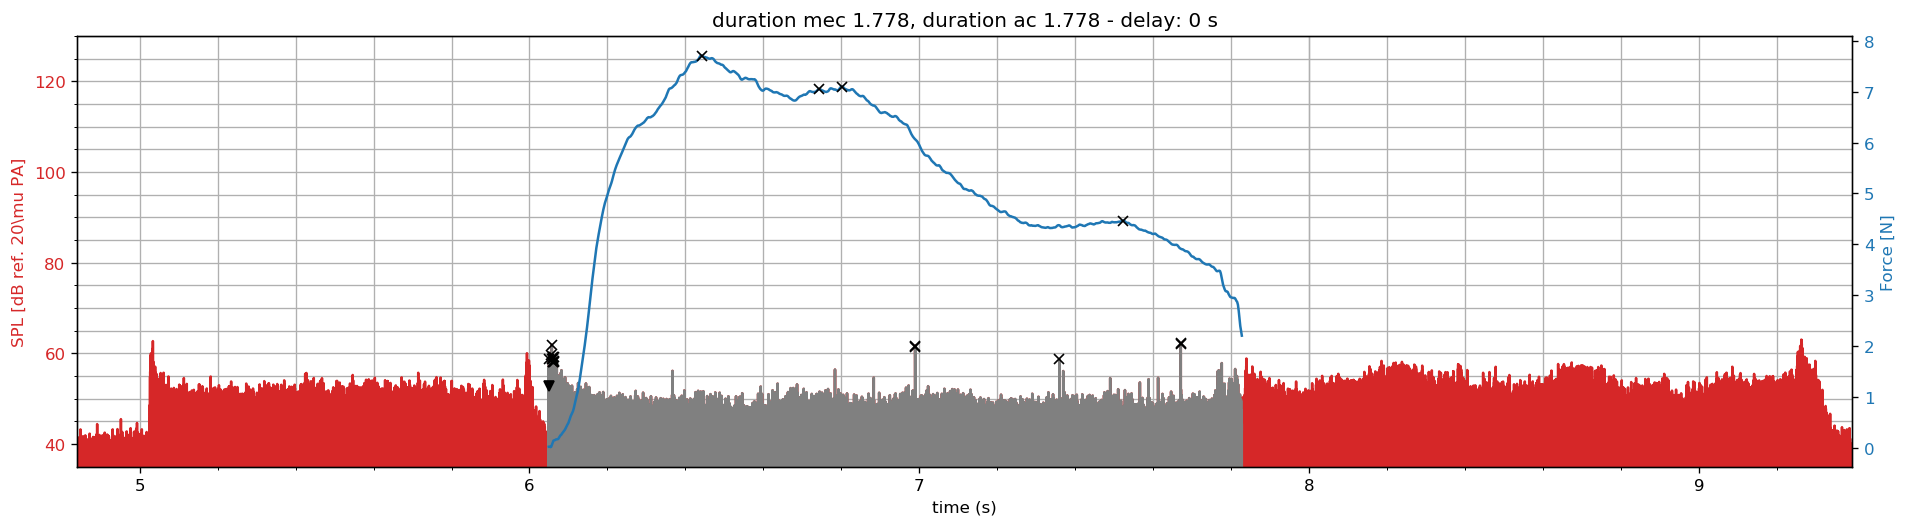

,linear_distance,max_force,mean_force,area,peaks_F,duration,spl_max,spl_10,spl_eq,npeaks_ac,duration,delay,cutpoints,filename,filename_mec,food type,test
0,17.139972,7.712377,5.284244,9.422576,4,1.778,62.270142,41.715045,59.772078,17,1.777969,0,309741,barra8,BARRA008,Barra de Cereal,Teste de Perfuração


In [72]:
p_raw = df['p'].values
t_ac = df['t'].values
filter_flag = True
## Filter
if not filter_flag:
    p = filt_data(p_raw,iir=False,show=False)
    filtflag = 'fir'
else:
    p = filt_data(p_raw,iir=True,show=False)
    filtflag = 'arimi'
p2 = filt_data(p_raw,iir=False,show=False)
    
t_ac_full = t_ac
p_full = p

## Sync -
if not load_sync:
    p, t_ac, duration_ac, cut_point = sync_data(p, t_ac, operation_threshold, peak_detection_treshold, SPL, duration_mec, duration_old, fs_ac)
else:
    cut_point = int(cutpoint_previous[iFile]) + int(delay*51200)
    p = p[int(cut_point):int(cut_point) + int(duration_mec*fs_ac)]
    t_ac = t_ac[cut_point:cut_point + int(duration_mec*fs_ac)]
    duration_ac = t_ac[-1] - t_ac[0]
    

    
# SPL_threshold = 54


peaks_SPL, _ = find_peaks(SPL(p), prominence=prominence_threshold, height=SPL_threshold)
if peaks_SPL.any():
    sorted_pks = np.array(sorted(SPL(p[peaks_SPL]), reverse=True))
    npeaks_ac = len(peaks_SPL)
else:
    sorted_pks = peaks_SPL
    npeaks_ac = 0

if len(sorted_pks) > 10:
    pks_10 = sorted_pks[0:9]
else:
    pks_10 = sorted_pks

if sorted_pks.any():
    spl_max = max(sorted_pks)
    spl_10 = 20*np.log10(np.mean(10**(pks_10/20)/len(pks_10)))
    spl_eq = 20*np.log10(np.mean(10**(sorted_pks/20)))
else:
    spl_max = 0
    spl_10 = 0
    spl_eq = 0
  
    
# all_data_mec.append([f, d, t_mec]) 
calc_data_mec = [[linear_distance, max_force, mean_force, area, npeaks_f, duration_mec]]
cut_points.append(cut_point)
calc_data_ac = [[spl_max, spl_10, spl_eq, npeaks_ac, duration_ac]]


fig, ax1 =plt.subplots(figsize=(16, 4.5), dpi=120, facecolor='w', edgecolor='k')
print('File {}/{}'.format(iFile+1, len(filepath_ac)))
sync_delay = (cut_point)/fs_ac                
plt.title('duration mec {:.5}, duration ac {:.5} - delay: {} s'.format(duration_mec, duration_ac, delay))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('SPL [dB ref. 20\mu PA]', color=color)
ax1.minorticks_on()
plt.plot(t_ac_full, SPL(p_full), color=color)
plt.plot(t_ac, SPL(p), color='gray')
plt.plot(sync_delay, SPL(p_full[cut_point]),'vk')
plt.plot(peaks_SPL/fs_ac+sync_delay, SPL(p[peaks_SPL]),'xk')
plt.xlim(cut_point*0.8/fs_ac, (cut_point/fs_ac + duration_mec)*1.2)
plt.ylim(35, 130)
plt.grid(True, which='both')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Force [N]', color=color)  # we already handled the x-label with ax1
plt.plot(t_mec+sync_delay, abs(f), color = color)
plt.plot(peaks_F/500+sync_delay, f[peaks_F],'xk')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped         
plt.show()
       
tests = [element.rsplit(os.sep, 3)[1] for element in filepath_ac]
food_types = [element.rsplit(os.sep, 2)[1] for element in filepath_ac]
filenames = [element.rsplit(os.sep, 1)[1][0:-4] for element in filepath_ac]
filenames_m = [element.rsplit(os.sep, 1)[1][0:-4] for element in filepath_mec]


df_ac_all = pd.DataFrame(calc_data_ac, columns=ac_headers)
df_mec_all = pd.DataFrame(calc_data_mec, columns=mec_headers)

full_df = pd.concat((df_mec_all,df_ac_all), axis=1)
full_df['delay'] = delay
full_df['cutpoints'] = cut_point
full_df['filename'] = filenames[iFile]
full_df['filename_mec'] = filenames_m[iFile]
full_df['food type'] = food_types[iFile]
full_df['test'] = tests[iFile]
full_df

In [73]:
def windowFig(x):
    norm = (x/100)
    fig, ax =plt.subplots(figsize=(16, 4.5), dpi=120, facecolor='w', edgecolor='k')
    cutpoint = cut_point/fs_ac
    ax.set_xlabel('time (s)')
    ax.set_ylabel('SPL [dB ref. 20\mu PA]', color=color)
    # plt.plot(t_ac_full,SPL(p_raw), color='k')

    # plt.plot(t_ac_full, SPL(p3),linewidth=2)
    plt.plot(t_ac_full, SPL(p_full),linewidth=2)
    # plt.plot(t_ac, SPL(p),':k',linewidth=0.8)
    plt.plot([cutpoint*0.8,(cutpoint+duration_mec)*1.2],[SPL_threshold,SPL_threshold],'--r')
    plt.legend([ 'Filtered data', 'Analysed data', 'SPL Treshold dB'])
    plt.plot(t_ac, SPL(p), color='gray')
    # plt.plot(sync_delay, SPL(p_full[cut_point]),'vk')
    plt.plot(peaks_SPL/fs_ac+sync_delay, SPL(p[peaks_SPL]),'xk')
    plt.xlim(cutpoint*0.8,(cutpoint+duration_mec)+1.2)
    # plt.xlim(cut, cut_point/fs_ac + duration_mec)*1.2
    plt.ylim(45, spl_max*1.1)
    plt.xlim(cut_point/fs_ac*(1-norm), (cut_point/fs_ac + duration_mec)*(1+(norm) ))



    ax.minorticks_on()

    plt.grid(True, which='both')
    plt.show()
#     plt.ylim(45, spl_max*1.2)
interact(windowFig,x=(0,100,0.1)) 

interactive(children=(FloatSlider(value=50.0, description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.windowFig(x)>

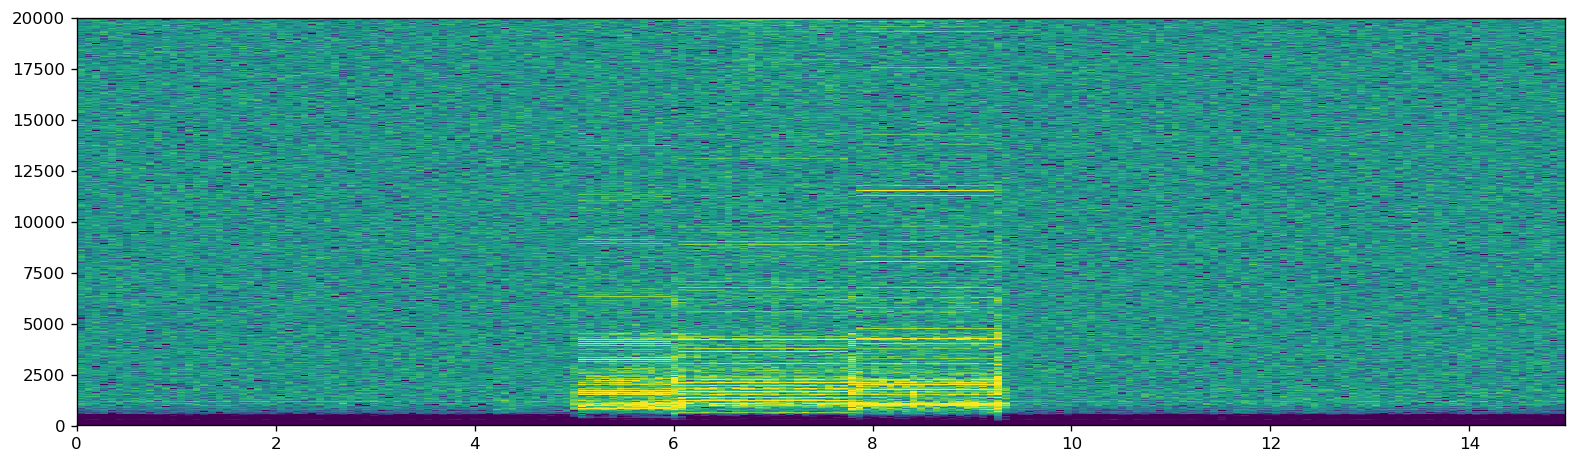

In [74]:
fig, ax2 =plt.subplots(figsize=(16, 4.5), dpi=120, facecolor='w', edgecolor='k')

Pxx, freqs, bins, im = ax2.specgram(p_full/2e-5, NFFT=4096,Fs=fs_ac,mode='magnitude',scale='dB',vmin=-30,vmax=20)
ax2.set_yscale('linear')
plt.ylim([10, 20000])
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [75]:
# def save_sync(ev):
#     global delay
    
#     delay = 0

#     display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index(), IPython.notebook.get_selected_index()+2)'))
    
# button4 = widgets.Button(description="save sync")
# button4.on_click(save_sync)
# display(button4)

In [76]:
# full_df['cutpoints'].values[0]

In [ ]:
# original = pd.read_excel('fir_cut_data_dyx.xls')
# original.loc[iFile]

In [ ]:
# original = pd.read_excel('fir_new_sync.xls')
# curr_file = full_df['filename'].values[0]
# original.set_index('filename',inplace=True)
# original.loc[curr_file,'cutpoints'] = full_df['cutpoints'].values[0]
# original.reset_index(inplace=True)
# original.to_excel('fir_new_sync.xls')
# original.iloc[iFile]